# import packages

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# DATA PREPARATION
## Load the training data and test data

In [3]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']

Data_id = "FD002"
#Cahit: correcting path
#train_FD = pd.read_table("./data/train_{}.txt".format(Data_id), header=None, delim_whitespace=True)
train_FD = pd.read_table("./data/C-MAPSS/train_{}.txt".format(Data_id), header=None, delim_whitespace=True)
train_FD.columns = column_name

#Cahit: correcting path
#test_FD = pd.read_table("./data/test_{}.txt".format(Data_id), header=None, delim_whitespace=True)
test_FD = pd.read_table("./data/C-MAPSS/test_{}.txt".format(Data_id), header=None, delim_whitespace=True)
test_FD.columns = column_name

#Cahit: correcting path
#RUL_FD = pd.read_table("./data/RUL_{}.txt".format(Data_id), header=None, delim_whitespace=True)
RUL_FD = pd.read_table("./data/C-MAPSS/RUL_{}.txt".format(Data_id), header=None, delim_whitespace=True) 

In [4]:
train_FD.describe()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000,53759.00000
mean,131.08298,109.15475,23.99841,0.57206,94.04602,472.91021,579.67240,1419.97101,1205.44202,8.03199,11.60075,282.60679,2228.87919,8525.20084,1.09496,42.98517,266.06903,2334.55725,8066.59768,9.32965,0.02333,348.30951,2228.80636,97.75684,20.78930,12.47342
std,74.46386,69.18057,14.74738,0.31002,14.23773,26.38971,37.28940,105.94634,119.12343,3.61384,5.43180,146.00531,145.20982,335.81201,0.12747,3.23237,137.65951,128.06827,84.83795,0.74934,0.00471,27.75452,145.32798,5.36407,9.86933,5.92162
min,1.00000,1.00000,0.00000,0.00000,60.00000,445.00000,535.53000,1243.73000,1023.77000,3.91000,5.71000,136.80000,1914.77000,7985.56000,0.93000,36.23000,129.12000,2027.61000,7848.36000,8.33570,0.02000,303.00000,1915.00000,84.93000,10.18000,6.01050
25%,68.00000,52.00000,10.00460,0.25070,100.00000,445.00000,549.57000,1352.76000,1123.65500,3.91000,5.72000,139.93500,2211.88000,8321.66000,1.02000,41.91000,131.52000,2387.90000,8062.14000,8.67780,0.02000,331.00000,2212.00000,100.00000,10.91000,6.54630
50%,131.00000,104.00000,25.00130,0.70000,100.00000,462.54000,555.98000,1369.18000,1138.89000,7.05000,9.03000,194.66000,2223.07000,8361.20000,1.02000,42.39000,183.20000,2388.08000,8082.54000,9.31090,0.02000,335.00000,2223.00000,100.00000,14.88000,8.92920
75%,195.00000,157.00000,41.99800,0.84000,100.00000,491.19000,607.34000,1499.37000,1306.85000,10.52000,15.49000,394.08000,2323.96000,8778.03000,1.26000,45.35000,371.26000,2388.17000,8127.19500,9.38690,0.03000,369.00000,2324.00000,100.00000,28.47000,17.08320
max,260.00000,378.00000,42.00800,0.84200,100.00000,518.67000,644.52000,1612.88000,1439.23000,14.62000,21.61000,555.82000,2388.39000,9215.66000,1.30000,48.51000,523.37000,2390.48000,8268.50000,11.06690,0.03000,399.00000,2388.00000,100.00000,39.34000,23.59010


# Compute the remaining useful life

### RUL for Training dataset

Here, we use the piecewise linear degradation model as the target function in the estimation process. 
The degradation of the system typically starts after a certain degree of usage, and hence, we consider this model to be more suited compared to the linear degradation model. [1](https://arxiv.org/abs/1810.05644)
![title](image/piecewise.png)

In [5]:
id='engine_id'
MAXLIFE = 120 # or 125 , 130
# piecewise linear RUL 
rul = [] 
for _id in set(train_FD[id]):
    trainFD_of_one_id =  train_FD[train_FD[id] == _id]
    cycle_list = trainFD_of_one_id['cycle'].tolist()
    max_cycle = max(cycle_list)

    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)
    rul.extend(kink_RUL)

train_FD["RUL"] = rul

### RUL for test dataset

In [6]:
id='engine_id'
rul = []
for _id_test in set(test_FD[id]):
    true_rul = int(RUL_FD.iloc[_id_test - 1])
    testFD_of_one_id =  test_FD[test_FD[id] == _id_test]
    cycle_list = testFD_of_one_id['cycle'].tolist()
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD["RUL"] = rul

# Feature extention

    Remove features that have only unique value
    
    Use correlation test methods (Significance test) to exclude features that are not related to the target variable

In [7]:
col_to_drop = identify_and_remove_unique_columns(train_FD)

In [8]:
train_FD = train_FD.drop(col_to_drop,axis = 1)

In [9]:
test_FD = test_FD.drop(col_to_drop,axis = 1)

## standard normalization 

In [10]:
mean = train_FD.iloc[:, 2:-1].mean()
std = train_FD.iloc[:, 2:-1].std()
std.replace(0, 1, inplace=True)


# training dataset
train_FD.iloc[:, 2:-1] = (train_FD.iloc[:, 2:-1] - mean) / std

# Testing dataset
test_FD.iloc[:, 2:-1] = (test_FD.iloc[:, 2:-1] - mean) / std

### plot a figure

training (53759, 16) (53759,)
testing (33991, 16) (33991,)


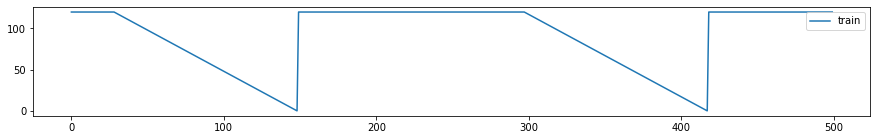

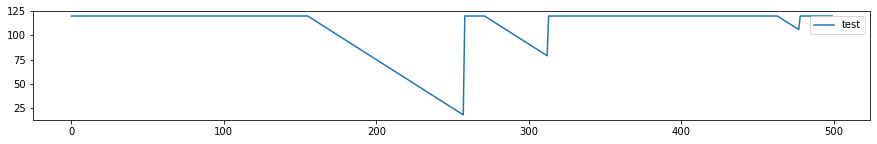

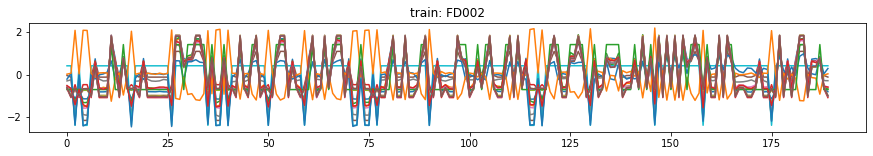

In [11]:
training_data = train_FD.values
testing_data = test_FD.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)

plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))

plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: " + Data_id )

plt.show()

# Data_Batch generation
    
Data generation with sliding window method
![title](image/sliding.png)
sequence_length defines the window movement steps

Window size defines the time steps included in the window

In the example above, the window size is 4, which is moved by one step

In [12]:
sequence_length=5
window_size = 16

# Prepare the training set according to the  window size and sequence_length
x_batch, y_batch = batch_generator(train_FD,sequence_length=sequence_length,window_size = window_size)

#Cahit: add a workaround for the deprecated behaviour. As of Numpy 1.18.0 axis MUST BE <= x_batch.ndim
#x_batch = np.expand_dims(x_batch, axis=4)
x_batch = np.expand_dims(x_batch, axis=min(4, x_batch.ndim))

#Cahit: add a workaround for the deprecated behaviour. As of Numpy 1.18.0 axis MUST BE <= y_batch.ndim
#y_batch = np.expand_dims(y_batch, axis=2)
y_batch = np.expand_dims(y_batch, axis=min(2, y_batch.ndim))

# Model

    Here is a novel variant called embedded convolutional LSTM (ECLSTM), It will be published on ECMLPKDD
    《Automatic Remaining Useful Life Estimation Framework with Embedded Convolutional LSTM as the Backbone》

In [13]:
from ECLSTM import ECLSTM1D

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed

    The network below has a four-layer architecture.
    The first layer is a ECLSTM layer with 10 filters, and the kernel size is 3.
    The second layer is a ECLSTM layer with 20 filters, and the kernel size is 3.
    The third is forward fully connected layers, with 150 hidden nodes. 
    The last layer is a 1-dimensional output layer which predicts the RUL. 
<font color=red>**This  model is not optimized， But it has been able to achieve state of the art results on FD002 and FD004 dataset. 
And the performance on FD001 and FD002 dataset is also better than the optimized traditional LSTM model.**</font> [2](https://ieeexplore.ieee.org/document/7998311) 

It shows that this new LSTM variant has stronger capabilities than LSTM in dealing with multiple time series problems (with large window size).

![title](image/tabel.png)

The RMSE values in this table are used as the baseline for comparison

In [22]:
# specify the achtecture parameters
para = {
    # preprocessing part
    "preprocessing_layers" : 0,
    "pre_kernel_width" : 3,
    "pre_number_filters" : 10,
    "pre_strides" : 2,
    "pre_activation" : "relu",


    # ECLSTM feature extraction part
    "eclstm_1_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_conv_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_kernel_width" : [3,3],
    "eclstm_1_number_filters" : [10,10],
    "eclstm_1_strides" : 1,
    "eclstm_1_fusion":["early","early"],
    
    "eclstm_2_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_conv_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_kernel_width" : [3,3],
    "eclstm_2_number_filters" : [20,20],
    "eclstm_2_strides" : 1,
    "eclstm_2_fusion":["early","early"],

    "eclstm_3_recurrent_activation" : [None],
    "eclstm_3_conv_activation" : [None],
    "eclstm_3_kernel_width" : [None],
    "eclstm_3_number_filters" : [None],
    "eclstm_3_strides" : None,
    "eclstm_3_fusion":[None],

    "eclstm_4_recurrent_activation" : [None],
    "eclstm_4_conv_activation" : [None],
    "eclstm_4_kernel_width" : [None],
    "eclstm_4_number_filters" : [None],
    "eclstm_4_strides" : None,
    "eclstm_4_fusion":[None],

    # Prediction
    "prediction_1_filters" : 150,
    "prediction_1_activation" : "relu",
    
    "prediction_2_filters" : 0,
    "prediction_2_activation" : None,
    
    "prediction_3_filters" : 0,
    "prediction_3_activation" : None,
    
    "prediction_4_filters" : 0,
    "prediction_4_activation" : None,
#}
## Cahit: possibly forgotten: append further elements from "para" defineition below
    # ECLSTM feature extraction part
    "eclstm_1_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_convolutional" : ["early","early"],

    "eclstm_2_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_convolutional" : ["early","early"],

    "eclstm_3_activation" : [None],
    "eclstm_3_convolutional" : [None],

    "eclstm_4_activation" : [None],
    "eclstm_4_convolutional" : [None],
}


In [23]:
# Cahit: adding possibly forgotten initialization of feature and window_size before their first usage 
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops

window_size = 20
feature = 16

In [24]:
initial_state = np.zeros((1,window_size,feature,1))
initial_state = tf.cast(initial_state, 'float32')
initial_state = K.zeros_like(initial_state)
shape = (3,1,1,10)
a = K.conv2d(initial_state, array_ops.zeros(tuple(shape)), (1,1))

In [25]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops

window_size = 20
feature = 16

def check_the_config_valid(para, window_size,feature):
    initial_state = np.zeros((1,window_size,feature,1))
    initial_state = tf.cast(initial_state, 'float32')
    initial_state = K.zeros_like(initial_state)
    channel = 1
    try:
        for i in range(para["preprocessing_layers"]):
            print(i,initial_state)
            shape = (para["pre_kernel_width"], 1, channel,para["pre_number_filters"])
            channel = para["pre_number_filters"]
            initial_state = K.conv2d(initial_state, array_ops.zeros(tuple(shape)), (para["pre_strides"],1))#,dilation_rate=(para["pre_dilation_rate"],1))


        for i in range(1,4):
            assert len(para["eclstm_{}_recurrent_activation".format(i)]) == len(para["eclstm_{}_conv_activation".format(i)]) == \
                   len(para["eclstm_{}_number_filters".format(i)]) == len(para["eclstm_{}_kernel_width".format(i)])== \
                   len(para["eclstm_{}_fusion".format(i)]), "Archtecture Parameters of {} layer should be in same length".format(i)

            for j in range(len(para["eclstm_{}_recurrent_activation".format(i)])):
                print(j,initial_state)
                if para["eclstm_{}_recurrent_activation".format(i)][0] is None:
                    break
                if para["eclstm_{}_fusion".format(i)][j] == "early":
                    shape = (para["eclstm_{}_kernel_width".format(i)][j], feature, channel,para["eclstm_{}_number_filters".format(i)][j] )
                    feature = 1
                    channel =     para["eclstm_{}_number_filters".format(i)][j]
                else :
                    shape = (para["eclstm_{}_kernel_width".format(i)][j], 1, channel,para["eclstm_{}_number_filters".format(i)][j] )
                    channel =     para["eclstm_{}_number_filters".format(i)][j]
                initial_state = K.conv2d(initial_state, array_ops.zeros(tuple(shape)), (para["eclstm_{}_strides".format(i)],1))
        return True
    except:
        print("Invalid Configuration! Try smaller strides or kernel size or greater window size!")
        return False
a = check_the_config_valid(para, window_size,feature)    

0 tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0

In [26]:
s = 2

model =Sequential()

model.add(ECLSTM1D(filters=[10,10], kernel_size=[3,3],
                           recurrent_activation=['linear',"hard_sigmoid"],
                           conv_activation = ['hard_sigmoid','hard_sigmoid'],
                           convolutional_type = ["early","early"],
                           strides = (1,1),
                           feature_number= 16,
                           input_shape=(None, 16, 16, 1), 
                           return_sequences=False))

from tensorflow.keras.layers import Input
input_test = Input(shape=(25,16, 16,1))
out = model(input_test)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
eclst_m1d_1 (ECLSTM1D)       (None, 12, 1, 10)         5900      
Total params: 5,900
Trainable params: 5,900
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
import tensorflow as tf

In [28]:
window_size = 200
feature = 16
channel = 1
initial_state = np.zeros((1,window_size,feature,1))
initial_state = tf.cast(initial_state, 'float32')
initial_state = K.zeros_like(initial_state)

for i in range(para["preprocessing_layers"]):
    shape = (para["pre_kernel_width"], 1, channel,para["pre_number_filters"])
    channel = para["pre_number_filters"]
    initial_state = K.conv2d(initial_state, array_ops.zeros(tuple(shape)), (para["pre_strides"],1))#,dilation_rate=(para["pre_dilation_rate"],1))
    print(initial_state)

for i in range(1,4):
    assert len(para["eclstm_{}_activation".format(i)]) == len(para["eclstm_{}_convolutional".format(i)]) == \
           len(para["eclstm_{}_number_filters".format(i)]) == len(para["eclstm_{}_kernel_width".format(i)]), \
            "Archtecture Parameters of {} layer should be in same length".format(i)
    
    for j in range(len(para["eclstm_{}_activation".format(i)])):
        
        if para["eclstm_{}_activation".format(i)][0] is None:
            break
        if para["eclstm_{}_fusion".format(i)][j] == "early":
            shape = (para["eclstm_{}_kernel_width".format(i)][j], feature, channel,para["eclstm_{}_number_filters".format(i)][j] )
            feature = 1
            channel =     para["eclstm_{}_number_filters".format(i)][j]
        else :
            shape = (para["eclstm_{}_kernel_width".format(i)][j], 1, channel,para["eclstm_{}_number_filters".format(i)][j] )
            channel =     para["eclstm_{}_number_filters".format(i)][j]
        initial_state = K.conv2d(initial_state, array_ops.zeros(tuple(shape)), (para["eclstm_{}_strides".format(i)],1))
        print(initial_state)


tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]]], shape=(1, 198, 1, 10), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]]], shape=(1, 196, 1, 10), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]]], shape=(1, 194, 1, 20), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]]], shape=(1, 192, 1, 20), dtype=float32)


In [31]:
##CB: add possibly forgotten initializations from below:
batch_size=15
seq=5
window=16 #Cahit: above "window_size" = 200 used, is it same as "window" = 16 below? which one is meant for input_test shape?
feature=16

input_test = keras.layers.Input(shape=(seq, window, feature,1))

input_test = tf.reshape(input_test, [-1, window, feature,1])
from keras.models import load_model, Model

model =Sequential()

out_test = keras.layers.Conv2D(3, (3, 1), strides=(1,1),padding="valid", activation="relu")(input_test)

model = Model(input_test, out_test)
#model.output


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: tf.reshape_1/Reshape:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 5, 16, 16, 1), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") at layer "tf.reshape_1". The following previous layers were accessed without issue: []

In [ ]:
out_test

In [ ]:
input_test

In [ ]:
data_input = Input(shape=(image_size[0], image_size[1], 2))

In [ ]:
# specify the achtecture parameters
para = {
    # preprocessing part
    "preprocessing_layers" : 0,
    "pre_kernel_width" : 3,
    "pre_number_filters" : 10,
    "pre_strides" : 2,
    #"pre_dilation_rate" : 1,
    "pre_activation" : ["relu"],


    # ECLSTM feature extraction part
    "eclstm_1_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_convolutional" : ["early","early"],
    "eclstm_1_kernel_width" : [kernel_size,kernel_size],
    "eclstm_1_number_filters" : [10,10],
    "eclstm_1_strides" : 1,
    "eclstm_1_fusion":["hybrid","early"],
    
    "eclstm_2_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_convolutional" : ["early","early"],
    "eclstm_2_kernel_width" : [kernel_size,kernel_size],
    "eclstm_2_number_filters" : [20,20],
    "eclstm_2_strides" : 1,
    "eclstm_2_fusion":["hybrid","hybrid"],

    "eclstm_3_activation" : [None],
    "eclstm_3_convolutional" : [None],
    "eclstm_3_kernel_width" : [None],
    "eclstm_3_number_filters" : [None],
    "eclstm_3_strides" : [None],
    "eclstm_3_fusion":[None],

    "eclstm_4_activation" : [None],
    "eclstm_4_convolutional" : [None],
    "eclstm_4_kernel_width" : [None],
    "eclstm_4_number_filters" : [None],
    "eclstm_4_strides" : [None],
    "eclstm_4_fusion":[None],
    
    # Prediction
    "prediction_1_filters" : 150,
    "prediction_1_activation" : "relu",
    
    "prediction_2_filters" : 0,
    "prediction_2_activation" : None,
    
    "prediction_3_filters" : 0,
    "prediction_3_activation" : None,
    
    "prediction_4_filters" : 0,
    "prediction_4_activation" : None,
}
# RUL Feature prediction part

In [ ]:
def build_the_model(para_dict, seq, window, feature):
    model =Sequential()
    if para_dict["preprocessing_layers"]>1:
        #model.add(keras.layers.Reshape((batch_size*seq, window, feature,1), input_shape=(batch_size, seq, window, feature,1)))
        
        for i in range(para["preprocessing_layers"]):
         
        
            model.add(keras.layers.Conv2D(para_dict["pre_number_filters"], (para_dict["pre_kernel_width"], 1), 
                                          strides=(para_dict["pre_strides"],1),
                                          padding="valid", activation=para_dict["pre_activation"][0]))
            
    model.add(keras.layers.Reshape(( seq, window, feature,1), input_shape=(window, feature,1)))
        
    return_sequences = True
    
    for i in range(1,5):
        if para["eclstm_{}_recurrent_activation".format(i)][0] is None:
            break
        if i==4:
            return_sequences = False
        elif para["eclstm_{}_recurrent_activation".format(i+1)][0] is None:
            return_sequences = False
            
            
        model.add(ECLSTM1D(filters=para["eclstm_{}_number_filters".format(i)], 
                           kernel_size=para["eclstm_{}_kernel_width".format(i)],
                           recurrent_activation=para["eclstm_{}_recurrent_activation".format(i)],
                           conv_activation = para["eclstm_{}_conv_activation".format(i)],
                           convolutional_type = para["eclstm_{}_fusion".format(i)],
                           strides = (para["eclstm_{}_strides".format(i)],1),
                           feature_number= feature,
                           return_sequences=return_sequences))

 

        model.add(keras.layers.BatchNormalization())
        
        if "early" in para["eclstm_{}_fusion".format(i)]:
            feature = 1
    model.add(Flatten())        
    for i in range(1,5):
        if para["prediction_{}_filters".format(i)]==0:
            break
        model.add(Dense(units = para["prediction_{}_filters".format(i)], 
                        activation = para["prediction_{}_activation".format(i)]))
    model.add(Dense(units = 1, activation = "linear"))
    
    model.compile(loss='mse', optimizer='Adam')
            
    return model

In [ ]:
batch_size=15
seq=5
window=16
feature=16
model = build_the_model(para, seq, window, feature)

input_test = keras.layers.Input(shape=(window, feature,1))
out = model(input_test)

print(model.summary())


In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
window_size = 16
feature = 16

x = np.zeros((1,window_size,feature,1))
x = tf.cast(x, 'float32')
initial_state = K.zeros_like(x)

for i in range(1,5):
    assert len(eval("eclstm_{}_activation".format(i)) == len(eval("eclstm_{}_convolutional".format(i)) == \
           len(eval("eclstm_{}_number_filters".format(i)) == len(eval("eclstm_{}_kernel_width".format(i)), \
            "Archtecture Parameters of {} layer should be in same length".format(i)
                                                                 
    if i == 1:
                                                                 
shape = (3, 1, 1, 10)
initial_state = K.conv2d(initial_state, array_ops.zeros(tuple(shape)))
shape = (3, 1, 10, 20)
conv_out = K.conv2d(initial_state, array_ops.zeros(tuple(shape)))
conv_out

In [ ]:

kernel_size = 3

model =Sequential()

model.add(ECLSTM1D(filters=[10,10], kernel_size=[kernel_size,kernel_size],recurrent_activation=['linear',"hard_sigmoid"],
                     input_channel= x_batch.shape[3],input_shape=(None, window_size, x_batch.shape[3], 1), return_sequences=True))


model.add(keras.layers.BatchNormalization())

model.add(ECLSTM1D(filters=[20,20], kernel_size=[kernel_size,kernel_size],recurrent_activation=['linear',"hard_sigmoid"],
                     input_channel= 1,return_sequences=False))

model.add(keras.layers.BatchNormalization())

model.add(Flatten())

model.add(Dense(units = 150, activation = "relu"))

model.add(Dense(units = 1, activation = "linear"))

model.compile(loss='mse', optimizer='Adam')

print(model.summary())

In [ ]:
import tensorflow.keras.callbacks as callback
logging = callback.TensorBoard()

In [ ]:
x_batch.shape

In [ ]:
# if you have enough time budget, you can set a large epochs and large patience
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,  mode='min')
mcp_save = callback.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
model.fit(x_batch,y_batch, batch_size=15, epochs=20, callbacks=[EarlyStopping, mcp_save],validation_split=0.075)

# Evaluation

##  Performance on training dataset

In [ ]:
y_batch_pred = model.predict(x_batch)

In [ ]:

y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
rmse_on_train = np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

print("The RMSE on test dataset {} is {}.".format(Data_id,rmse_on_train))

##  Performance on test dataset

In [ ]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [ ]:
# We provide 4 trained models. You can load the model with the following command
# -------------------------------------
#  model.load_weights('trained_models/best_model_{}.h5'.format(Data_id))

In [ ]:
# model.load_weights('trained_models/best_model_{}.h5'.format(Data_id))

In [ ]:
model.load_weights('best_model_FD002_1.h5')

In [ ]:
y_batch_pred_test = model.predict(x_batch_test)

In [ ]:
rmse_on_test = np.sqrt(mean_squared_error(y_batch_pred_test, y_batch_test))
print("The RMSE on test dataset {} is {}.".format(Data_id,rmse_on_test))

# potential

* Time series usually need pre-processing, such as reducing noise or doing difference. Proper preprocessing will help the model have better results. 1D convolution can be used as the preprocessing part.

    

* The model above is not optimized for each data set, If the model is optimized separately for each data set, the results will be better.

    
    
* How to effectively set these hyperparameters? automated machine learning



![title](image/final.png)

The figure shows the average RMSE